# PJM Load Data Analysis

This notebook provides an automated analysis of the PJM hourly load dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Set project and data directories
DATA_DIR = Path('data/PJM hourly load data')

print(f"Dataset Directory: {DATA_DIR.absolute()}")

Dataset Directory: /Users/rakeshkrai/Desktop/AgentField/data/PJM hourly load data


## 1. List files in the dataset directory

In [2]:
files = [f for f in os.listdir(DATA_DIR) if not f.startswith('.')]
print("Files found:")
for f in sorted(files):
    size = (DATA_DIR / f).stat().st_size / (1024 * 1024)
    print(f"- {f} ({size:.2f} MB)")

Files found:
- AEP_hourly.csv (3.24 MB)
- COMED_hourly.csv (1.76 MB)
- DAYTON_hourly.csv (3.12 MB)
- DEOK_hourly.csv (1.49 MB)
- DOM_hourly.csv (3.06 MB)
- DUQ_hourly.csv (3.07 MB)
- EKPC_hourly.csv (1.16 MB)
- FE_hourly.csv (1.62 MB)
- NI_hourly.csv (1.55 MB)
- PJME_hourly.csv (3.88 MB)
- PJMW_hourly.csv (3.69 MB)
- PJM_Load_hourly.csv (0.88 MB)
- est_hourly.paruqet (3.51 MB)
- pjm_hourly_est.csv (12.12 MB)


## 2. Automatically find the main CSV
We search for the largest CSV file as the likely primary dataset.

In [3]:
csv_files = [f for f in files if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV files found in the dataset directory.")

# Heuristic: The largest CSV is likely the main one
main_csv = max(csv_files, key=lambda f: (DATA_DIR / f).stat().st_size)
csv_path = DATA_DIR / main_csv

print(f"Main CSV detected: {main_csv}")

Main CSV detected: pjm_hourly_est.csv


## 3. Load Data

In [4]:
df = pd.read_csv(csv_path)

print("\n--- Column Names ---")
print(df.columns.tolist())

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Head ---")
display(df.head())

print("\n--- Tail ---")
display(df.tail())


--- Column Names ---
['Datetime', 'AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'EKPC', 'FE', 'NI', 'PJME', 'PJMW', 'PJM_Load']

--- Data Types ---
Datetime     object
AEP         float64
COMED       float64
DAYTON      float64
DEOK        float64
DOM         float64
DUQ         float64
EKPC        float64
FE          float64
NI          float64
PJME        float64
PJMW        float64
PJM_Load    float64
dtype: object

--- Head ---


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
0,1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1,1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
2,1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
3,1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
4,1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0



--- Tail ---


,Datetime,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
178257,2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
178258,2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
178259,2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN
178260,2018-01-01 23:00:00,20415.0,13336.0,2614.0,4224.0,17814.0,1820.0,2880.0,8676.0,NaN,40164.0,7958.0,NaN
178261,2018-01-02 00:00:00,19993.0,12816.0,2552.0,4100.0,17428.0,1721.0,2846.0,8393.0,NaN,38608.0,7691.0,NaN


## 4. Detect Datetime and Parse

In [5]:
# Detect datetime column
date_cols = [col for col in df.columns if 'Datetime' in col or 'date' in col.lower()]
if not date_cols:
    # Try searching for columns that look like dates in content if name detection fails
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                pd.to_datetime(df[col].head(5))
                date_cols.append(col)
                break
            except:
                pass

if date_cols:
    date_col = date_cols[0]
    print(f"Detected datetime column: {date_col}")
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)
    df.set_index(date_col, inplace=True)
else:
    print("Could not automatically detect a datetime column.")

Detected datetime column: Datetime


## 5. Detect Numeric Load Columns (MW)

In [6]:
load_cols = [col for col in df.columns if 'MW' in col.upper() or 'load' in col.lower()]
if not load_cols:
    # Fallback to any numeric column that isn't an ID
    load_cols = df.select_dtypes(include=['number']).columns.tolist()

print(f"Detected load columns: {load_cols}")

Detected load columns: ['PJMW', 'PJM_Load']


## 6. Data Quality Report

In [7]:
print(f"Missing values:\n{df.isnull().sum()}")
print(f"\nDuplicate rows: {df.duplicated().sum()}")

if isinstance(df.index, pd.DatetimeIndex):
    # Check for gaps in hourly frequency
    expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
    missing_timestamps = expected_range.difference(df.index)
    print(f"\nTotal expected hourly timestamps: {len(expected_range)}")
    print(f"Actual timestamps: {len(df)}")
    print(f"Missing hourly timestamps: {len(missing_timestamps)}")
    if len(missing_timestamps) > 0:
        print("First 5 missing timestamps:")
        print(missing_timestamps[:5])

Missing values:
AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

Duplicate rows: 16181

Total expected hourly timestamps: 178296
Actual timestamps: 178262
Missing hourly timestamps: 38
First 5 missing timestamps:
DatetimeIndex(['1998-04-05 03:00:00', '1998-10-25 02:00:00',
               '1999-04-04 03:00:00', '1999-10-31 02:00:00',
               '2000-04-02 03:00:00'],
              dtype='datetime64[ns]', freq=None)


# Preprocessing: canonical hourly PJM load dataset

This section implements a robust preprocessing pipeline to create a canonical dataset for modeling. 

**Pipeline Stages:**
1. **Sorting**: Ensure strict temporal ordering.
2. **Duplicate Resolution**: Handle DST fall-back duplicates via aggregation.
3. **Reindexing**: Complete the hourly timeline and detect gaps.
4. **Imputation**: Fill missing hours (e.g., DST spring-forward) using time-based interpolation and catch-all fill logic.
5. **Feature Engineering**: Add time-based features and convert units.
6. **Scaling**: Region-wise MinMax scaling.

In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path

# Constants
OUT_DIR = Path('output')
OUT_DIR.mkdir(exist_ok=True)
FREQ = 'h'

def fit_minmax(train_series):
    """Fits a MinMaxScaler to the series and returns parameters."""
    scaler = MinMaxScaler()
    scaler.fit(train_series.values.reshape(-1, 1))
    return scaler

def transform_minmax(series, scaler):
    """Applies a fitted scaler to a series."""
    return scaler.transform(series.values.reshape(-1, 1)).flatten()

print("Preprocessing utilities initialized.")

Preprocessing utilities initialized.


### 2) Sort correctly and validate ordering

In [9]:
# MELT the dataframe into long format for easier per-region processing
df_long = df.reset_index().melt(id_vars='Datetime', var_name='region', value_name='load_mw')
df_long = df_long.rename(columns={'Datetime': 'datetime'})

# Sort and reset index
df_long = df_long.sort_values(['region', 'datetime']).reset_index(drop=True)
print(f"Long-format dataset created. Shape: {df_long.shape}")
display(df_long.head())

Long-format dataset created. Shape: (2139144, 3)


,datetime,region,load_mw
0,1998-04-01 01:00:00,AEP,NaN
1,1998-04-01 02:00:00,AEP,NaN
2,1998-04-01 03:00:00,AEP,NaN
3,1998-04-01 04:00:00,AEP,NaN
4,1998-04-01 05:00:00,AEP,NaN


### 3) Fix duplicates (especially DST fall-back duplicates)

In [10]:
dup_report = []

def resolve_duplicates(group):
    region = group.name
    dup_mask = group.duplicated('datetime', keep=False)
    if dup_mask.any():
        dups = group[dup_mask]
        for dt, sub_group in dups.groupby('datetime'):
            dup_report.append({
                'region': region, 
                'duplicate_datetime': dt, 
                'count': len(sub_group), 
                'mean_value': sub_group['load_mw'].mean()
            })
        agg_group = group.groupby('datetime', as_index=False).agg({'load_mw': 'mean'})
        agg_group['region'] = region
        return agg_group
    return group

df_dedup = df_long.groupby('region', group_keys=False).apply(resolve_duplicates)
df_dedup_report = pd.DataFrame(dup_report)

print(f'Resolved {len(df_dedup_report)} unique duplicate timestamps.')

Resolved 48 unique duplicate timestamps.


/var/folders/cz/lpd4tzvs1nb5zqt1vyb31tl00000gn/T/ipykernel_50856/2163089048.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_dedup = df_long.groupby('region', group_keys=False).apply(resolve_duplicates)


### 4) Reindex to complete hourly timeline

In [11]:
reindexed_list = []
missing_report = []

for region, group in df_dedup.groupby('region'):
    group = group.set_index('datetime')
    full_index = pd.date_range(start=group.index.min(), end=group.index.max(), freq=FREQ)
    reindexed = group.reindex(full_index)
    
    missing_mask = reindexed['load_mw'].isna()
    if missing_mask.any():
        missing_pts = reindexed[missing_mask].index
        for dt in missing_pts:
            missing_report.append({'region': region, 'missing_datetime': dt})
            
    reindexed = reindexed.reset_index().rename(columns={'index': 'datetime'})
    reindexed['region'] = region
    reindexed_list.append(reindexed)

df_reindexed = pd.concat(reindexed_list, ignore_index=True)
print(f'Detected {len(missing_report)} missing hourly timestamps.')

Detected 1049425 missing hourly timestamps.


### 5) Impute missing timestamps safely

We fill gaps using `time` interpolation with `limit_direction='both'` and a final `.ffill().bfill()` to ensure zero NaNs.

In [12]:
fill_report = []
IMPUTE_METHOD = 'time'

def impute_gaps(group):
    region = group.name
    group = group.set_index('datetime')
    missing_mask = group['load_mw'].isna()
    
    if missing_mask.any():
        if IMPUTE_METHOD == 'time':
            group['load_mw'] = group['load_mw'].interpolate(method='time', limit_direction='both')
        else:
            group['load_mw'] = (group['load_mw'].shift(1) + group['load_mw'].shift(-1)) / 2.0
        
        # Safety catch-all for remaining NaNs (e.g. at the start or end of the series)
        group['load_mw'] = group['load_mw'].ffill().bfill()
    return group.reset_index()

df_canonical = df_reindexed.groupby('region', group_keys=False).apply(impute_gaps)
print(f'Imputation completed. NaNs remaining: {df_canonical["load_mw"].isna().sum()}')
assert df_canonical['load_mw'].isna().sum() == 0, 'There are still NaNs in the load_mw column!'

Imputation completed. NaNs remaining: 0


/var/folders/cz/lpd4tzvs1nb5zqt1vyb31tl00000gn/T/ipykernel_50856/2702222028.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_canonical = df_reindexed.groupby('region', group_keys=False).apply(impute_gaps)


### 6) Add derived time features & Clarify units

In [13]:
df_canonical['hour'] = df_canonical['datetime'].dt.hour
df_canonical['dayofweek'] = df_canonical['datetime'].dt.dayofweek
df_canonical['month'] = df_canonical['datetime'].dt.month
df_canonical['year'] = df_canonical['datetime'].dt.year
df_canonical['is_weekend'] = df_canonical['dayofweek'].isin([5, 6]).astype(int)
df_canonical['energy_mwh'] = df_canonical['load_mw'] * 1.0
print('Features added and units clarified.')
display(df_canonical.head())

Features added and units clarified.


,datetime,load_mw,region,hour,dayofweek,month,year,is_weekend,energy_mwh
0,1998-04-01 01:00:00,12379.0,AEP,1,2,4,1998,0,12379.0
1,1998-04-01 02:00:00,12379.0,AEP,2,2,4,1998,0,12379.0
2,1998-04-01 03:00:00,12379.0,AEP,3,2,4,1998,0,12379.0
3,1998-04-01 04:00:00,12379.0,AEP,4,2,4,1998,0,12379.0
4,1998-04-01 05:00:00,12379.0,AEP,5,2,4,1998,0,12379.0


### 8) Scaling for model training

In [14]:
scaled_dfs = []
for region, group in df_canonical.groupby('region'):
    scaler = fit_minmax(group['load_mw'])
    group['load_mw_scaled'] = transform_minmax(group['load_mw'], scaler)
    scaled_dfs.append(group)

df_canonical = pd.concat(scaled_dfs, ignore_index=True)
print('MinMax scaling applied per region.')

MinMax scaling applied per region.


### 9) Output canonical dataset(s)

In [15]:
df_canonical_wide = df_canonical.pivot(index='datetime', columns='region', values='load_mw')
df_canonical.to_csv(OUT_DIR / 'pjm_canonical_long.csv', index=False)
df_canonical_wide.to_csv(OUT_DIR / 'pjm_canonical_wide.csv')
print(f'Datasets saved to {OUT_DIR}/')

Datasets saved to output/


### 10) Quick plots for verification

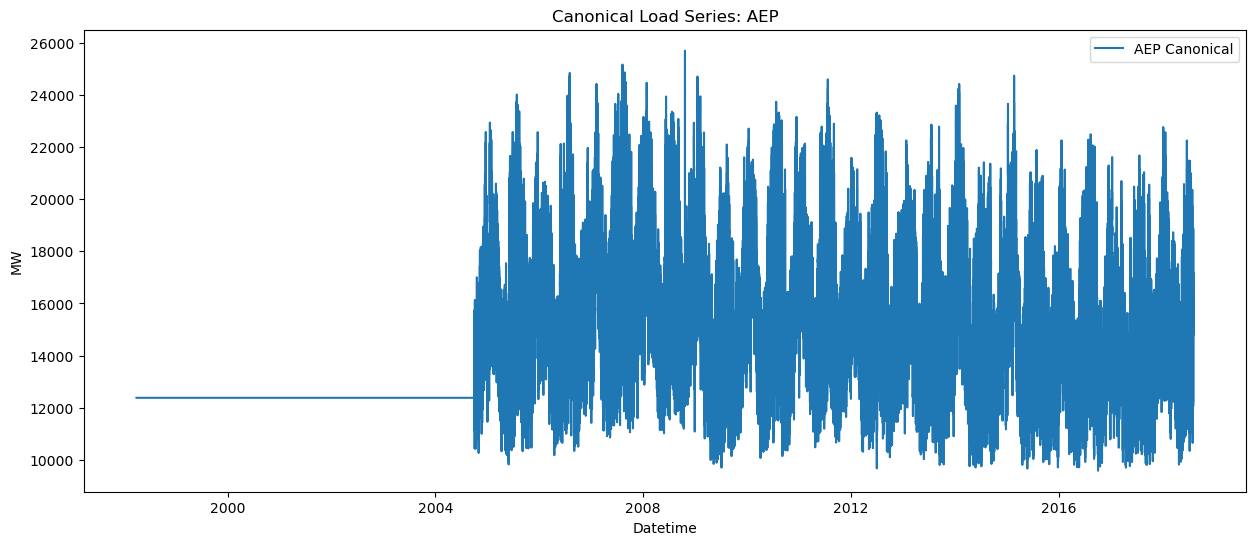

In [16]:
sample_region = sorted(df_canonical['region'].unique())[0]
subset = df_canonical[df_canonical['region'] == sample_region]
plt.figure(figsize=(15, 6))
plt.plot(subset['datetime'], subset['load_mw'], label=f'{sample_region} Canonical')
plt.title(f'Canonical Load Series: {sample_region}')
plt.xlabel('Datetime')
plt.ylabel('MW')
plt.legend()
plt.show()

## 7. Visualization

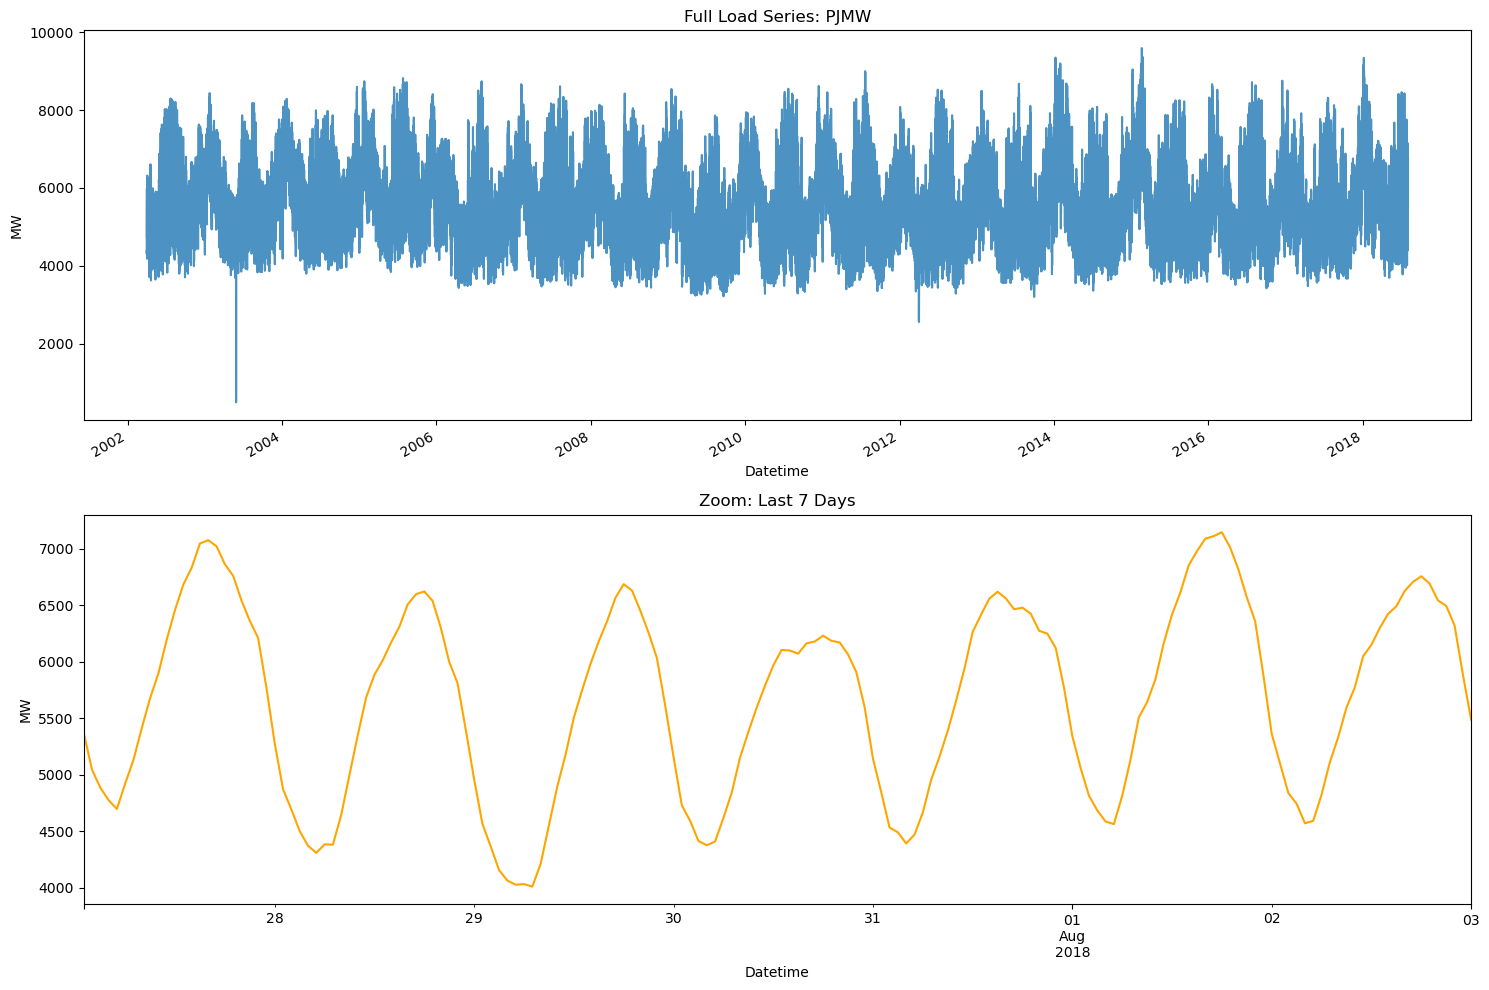

In [17]:
if load_cols:
    primary_load = load_cols[0]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Main Load Series
    df[primary_load].plot(ax=ax1, title=f'Full Load Series: {primary_load}', alpha=0.8)
    ax1.set_ylabel('MW')
    
    # 7-day Zoom
    if len(df) > 24 * 7:
        last_7_days = df.iloc[-(24 * 7):]
        last_7_days[primary_load].plot(ax=ax2, title='Zoom: Last 7 Days', color='orange')
        ax2.set_ylabel('MW')
    
    plt.tight_layout()
    plt.show()
else:
    print("No load columns identified for plotting.")

## 9. Loading Wind Time Series (NetCDF)

We select a subset of sites and load their hourly wind time series.

## 10. Temporal Alignment (2007-2013)

Aligning wind data with PJM load data on the hourly scale for the years 2007-2013.